In [ ]:
using(BenchmarkTools)

In [1]:
import(Optim)
import(JSON)
import(Plots)

In [2]:
mutable struct Graph
    chains::Array{Array{String,1},1}
    nodes::Dict{String,Int64}
    coords::Union{Nothing, Array{Float64,2}}
end

# from node key (string) to index, to coords
function get_coords(graph, n)
    return graph.coords[[1, 2], graph.nodes[n]]
    end;

function printinfo(x::Graph)
    println(length(x.nodes), " nodes")
    println(length(x.chains), " chains")
    end;

# Graph the graph
function graphplot(graph::Graph)
    fig = Plots.plot(legend=false, aspect_ratio=:equal)
    #scatter!(coords[:, 1], coords[:, 2], linewidth=2)
    for chain in graph.chains
        chain_xy = map(x -> graph.coords[[1, 2], graph.nodes[x]], chain);
        x = getindex.(chain_xy, 1)
        y = getindex.(chain_xy, 2)
        Plots.plot!(x, y, linewidth=3)
        #println(coords[idx, 1])
        end;
    fig
    end;

# Define the (entire) graph
function init_graph_from_chains(chains)
    nodes_list = unique(n for ch in chains for n in ch)
    nodes = Dict( n=>k for (k, n) in enumerate(nodes_list) )

    fullgraph = Graph(chains, nodes, nothing);
    end;

In [30]:
## Force Layout 
const EPSILON = 1e-7

# Spring (+2 power)
function spring_energy(u, v)
    return (u^2 + v^2)
    end;
function spring_gradient(u, v)
    return (2*u, 2*v)
    end;

# Electric  (-2 power)
function repulsive_Coulomb_energy(u, v)
    return 1/(u^2 + v^2 + EPSILON)
    end;
function repulsive_Coulomb_gradient(u, v)
    d4 = (u^2 + v^2 + EPSILON)^2
    return (-2*u/d4, -2*v/d4)
    end;

# Inverse distance (-1 power)
function inverse_dist_energy(u, v)
    return 1/sqrt(u^2 + v^2 + EPSILON)
    end;

function inverse_dist_gradient(u, v)
    d3 = sqrt(u^2 + v^2 + EPSILON)^3
    return (-u/d3, -4*v/d3)
    end;

# The (attraction,repulsion)-model of ForceAtlas (1,-1)
# has an intermediate position between Noack’s LinLog (0,-1)
# and the algorithm of Fruchterman and Rheingold (2,-1),
# https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0098679&type=printable

attractive_energy = spring_energy
attractive_gradient = spring_gradient
repulsive_energy = repulsive_Coulomb_energy
repulsive_gradient = repulsive_Coulomb_gradient

repulsive_Coulomb_gradient (generic function with 1 method)

In [37]:
## Stillou Webou
function three_body_energy(x0, x1, x2, x3, x4, x5)
    u0 = -x0 + x2
    u1 = -x1 + x3
    u2 = -x2 + x4
    u3 = -x3 + x5
    return (-1 + (u0*u2 + u1*u3)/(sqrt(u0^2 + u1^2)*sqrt(u2^2 + u3^2)))^2
    end;

function three_body_gradient(x0, x1, x2, x3, x4, x5)
    u0 = -x0 + x2
    u1 = -x2
    u2 = u1 + x4
    u3 = -x1 + x3
    u4 = -x3
    u5 = u4 + x5
    u6 = u0*u2 + u3*u5
    u7 = u0^2 + u3^2
    u8 = 1/sqrt(u7)
    u9 = u2^2 + u5^2
    u10 = 1/sqrt(u9)
    u11 = u10*u8
    u12 = u11*u6 - 1
    u13 = x2 - x4
    u14 = 2*u11
    u15 = 2*u6
    u16 = u10*u15/u7^(3/2)
    u17 = x3 - x5
    u18 = u15*u8/u9^(3/2)
        
    return (u12*(u0*u16 + u13*u14), 
            u12*(u14*u17 + u16*u3), 
            u12*(u14*(x0 - 2*x2 + x4) + u16*(u1 + x0) + u18*u2), 
            u12*(u14*(x1 - 2*x3 + x5) + u16*(u4 + x1) + u18*u5), 
            u12*(u0*u14 + u13*u18), 
            u12*(u14*u3 + u17*u18) )
    end;

In [36]:
three_body_gradient(-1, 0, 0, 0, 1, 0)

(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [25]:
function graph_gradient!(G, coords, graph)
    fill!(G, 0.f0)
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            u = x2 - x1
            v = y2 - y1
            grad = attractive_gradient(u, v)
            G[1, i1] -= grad[1]
            G[2, i1] -= grad[2]
            G[1, i2] += grad[1]
            G[2, i2] += grad[2]
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            u = x2 - x1
            v = y2 - y1
            grad = repulsive_gradient(u, v)
            G[1, i] -= grad[1]
            G[2, i] -= grad[2]
            G[1, j] += grad[1]
            G[2, j] += grad[2]
            end;
        end;
    
        # Moment
    #for chain in graph.chains
    #    for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
    #        i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
    #        x1, y1 = coords[1, i1], coords[2, i1]
    #        #x2, y2 = coords[1, i2], coords[2, i2]
    #        x3, y3 = coords[1, i3], coords[2, i3]
    #        #u12 = x2 - x1
    #        #v12 = y2 - y1
    #        u13 = x3 - x1
    #        v13 = y3 - y1
    #        
    #        grad = low_repulsive_gradient(u13, v13)
    #        G[1, i1] += grad[1]
    #        G[2, i1] += grad[2]
    #        G[1, i3] -= grad[1]
    #        G[2, i3] -= grad[2]
    #        end
    #end
    
    end;

function graph_energy(coords, graph)
    E = 0
    # Attractive
    for chain in graph.chains
        for (n1, n2) in zip(chain[1:end-1], chain[2:end])
            i1, i2 = graph.nodes[n1], graph.nodes[n2]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            u = x2 - x1
            v = y2 - y1
            E += attractive_energy(u, v)
            end;
        end;
    
    # Repulsive
    # Todo: insert Barnes Hut here...
    for i in 1:length(graph.nodes)
        x1, y1 = coords[1, i], coords[2, i]
        for j in i+1:length(graph.nodes)
            x2, y2 = coords[1, j], coords[2, j]
            u = x2 - x1
            v = y2 - y1
            E += repulsive_energy(u, v)
            end;
        end;

    ## Moment
    #for chain in graph.chains
    #    for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
    #        i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
    #        x1, y1 = coords[1, i1], coords[2, i1]
    #        #x2, y2 = coords[1, i2], coords[2, i2]
    #        x3, y3 = coords[1, i3], coords[2, i3]
    #        #u12 = x2 - x1
    #        #v12 = y2 - y1
    #        u13 = x3 - x1
    #        v13 = y3 - y1
    #        
    #        E += low_repulsive_energy(u13, v13)

    #        end
    #end
    
    return E
    end;

In [26]:
function optimize!(graph)
    coords = copy(graph.coords)
    G = zeros(Float32, size(coords)...)
    result = Optim.optimize(x->graph_energy(x, graph),
                            (G, x)->graph_gradient!(G, x, graph),
                            coords, #Optim.GradientDescent(),
                             Optim.Options(g_tol = 1e-7,
                                           iterations = 2000,
                                           store_trace = false,
                                           show_trace = false)
    )

    # convert back to a "normal" graph
    graph.coords = result.minimizer;
    result
    end;


In [14]:
# ====================
# Load graph from Json
files = filter(x -> endswith(x, "_chains.json"), readdir("./data/"))

println(files)

file_name = files[1]
path = string("./data/", file_name)
data = read(path, String)
d = []
chains = JSON.parse(data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println("number of chains: ", length(chains))

["177539135_99_chains.json"]
number of chains: 14


In [6]:
# test graph
chains = [["A", "B", "C", "D", "E", "ez", "zra"],
    ["R", "E", "T", "ER", "erz", "ZE"]]#, ["E", "F", "G"]]#, ["A", "1", "2", "G"]]

2-element Array{Array{String,1},1}:
 ["A", "B", "C", "D", "E", "ez", "zra"]
 ["R", "E", "T", "ER", "erz", "ZE"]    

In [15]:
graph = init_graph_from_chains(chains);
printinfo(graph)

99 nodes
14 chains


In [27]:
# init coords (circle)
N = length(graph.nodes)
radius = N/(2*pi)
graph.coords = hcat([[radius*cos(k*2*pi/N); radius*sin(k*2*pi/N)] for k in 1:N]...);
# gradient
G = zeros(Float64, size(graph.coords)...);

In [28]:
res = optimize!(graph)

 * Status: failure (objective increased between iterations) (line search failed)

 * Candidate solution
    Minimizer: [9.77e+00, 1.94e+00, 9.36e+00,  ...]
    Minimum:   3.434622e+02

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [1.57e+01, 9.99e-01, 1.56e+01,  ...]

 * Convergence measures
    |x - x'|               = 5.04e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.01e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.19e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.48e-15 ≰ 0.0e+00
    |g(x)|                 = 4.69e-07 ≰ 1.0e-07

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    1103
    f(x) calls:    3299
    ∇f(x) calls:   3299


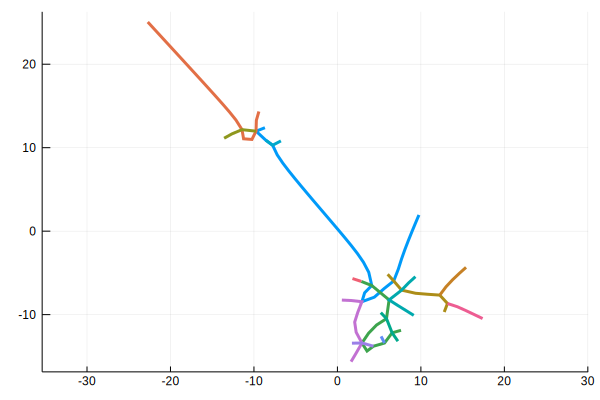

In [29]:
graphplot(graph)

In [32]:
# Export coords to json
exportfilename = replace(path, "_chains.json"=>"_coords.json")
println(exportfilename)
coords_dict = Dict(n => (graph.coords[1, idx], graph.coords[2, idx])
                   for (n, idx) in pairs(graph.nodes) );

println(length(coords_dict), " coords")
open(exportfilename, "w") do io
    JSON.print(io, coords_dict, 0)
    end;

./data/028295730_294_coords.json
293 coords


## draft

In [ ]:
    # Moment
    for chain in graph.chains
        for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
            i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
            x1, y1 = coords[1, i1], coords[2, i1]
            x2, y2 = coords[1, i2], coords[2, i2]
            x3, y3 = coords[1, i3], coords[2, i3]
            u12 = x2 - x1
            v12 = y2 - y1
            u23 = x3 - x1
            v23 = y3 - y2
            
            d12_sq = u12^2 + v12^2
            d23_sq = u23^2 + v23^2

            dot = u12*u23 + v12*v23
            
            E -= 35.0*dot/sqrt(d12_sq*d23_sq + EPSILON)
            end
    end

In [ ]:
E = 0.0
for chain in graph.chains
    for (n1, n2, n3) in zip(chain[1:end-2], chain[2:end-1], chain[3:end])
        i1, i2, i3 = graph.nodes[n1], graph.nodes[n2], graph.nodes[n3]
        x1, y1 = coords[1, i1], coords[2, i1]
        x2, y2 = coords[1, i2], coords[2, i2]
        x3, y3 = coords[1, i3], coords[2, i3]
        #u12 = x2 - x1
        v12 = y2 - y1
        #u23 = x3 - x1
        v23 = y3 - y2
        u13 = x3 - x1
        E += 1 - v12*v23./(sqrt(u13^2 + v12^2 + EPSILON)*abs(v23 + EPSILON))
    end
end